In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

> https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [ ]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [ ]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
##### remove blood_cell in blood_cell
source_dir = '/content/blood_cell/blood_cell'
target_dir = '/content/blood_cell'

# Get a list of directories in the source directory
directories = next(os.walk(source_dir))[1]

# Move each directory to the target directory
for directory in directories:
    source_path = os.path.join(source_dir, directory)
    target_path = os.path.join(target_dir, directory)
    shutil.move(source_path, target_path)

directory_to_remove = '/content/blood_cell/blood_cell'

# Remove the directory and its contents
shutil.rmtree(directory_to_remove)

In [ ]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))


test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : NEUTROPHIL  =>  2499
test label : MONOCYTE  =>  2478
test label : LYMPHOCYTE  =>  2483
test label : EOSINOPHIL  =>  2497
['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : NEUTROPHIL  =>  624
test label : MONOCYTE  =>  620
test label : LYMPHOCYTE  =>  620
test label : EOSINOPHIL  =>  623
['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
val label : NEUTROPHIL  =>  48
val label : MONOCYTE  =>  4
val label : LYMPHOCYTE  =>  6
val label : EOSINOPHIL  =>  13


In [ ]:
##### Let's shuffle

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']


In [ ]:
##### Move to TRAIN at all files in TEST
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

624 is moved into NEUTROPHIL(TEST => Train)
620 is moved into MONOCYTE(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)
623 is moved into EOSINOPHIL(TEST => Train)


In [ ]:
##### Move to TRAIN all files in TEST_SIMPLE
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)
4 is moved into MONOCYTE(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)
13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)


In [ ]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : NEUTROPHIL  =>  3171
test label : MONOCYTE  =>  3095
test label : LYMPHOCYTE  =>  3108
test label : EOSINOPHIL  =>  3133


In [ ]:

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1

    print("total move num => ", move_num)
    print("=============================================")

total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634
total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621
total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626


In [ ]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : NEUTROPHIL  =>  2537
test label : MONOCYTE  =>  2476
test label : LYMPHOCYTE  =>  2487
test label : EOSINOPHIL  =>  2507
['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : NEUTROPHIL  =>  634
test label : MONOCYTE  =>  619
test label : LYMPHOCYTE  =>  621
test label : EOSINOPHIL  =>  626


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 224, 224, 3) (16,)
[2. 3. 0. 2. 0. 0. 1. 3. 2. 1. 2. 0. 3. 1. 1. 2.]
87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
           

251/251 [==============================] - 102s 255ms/step - loss: 1.4295 - acc: 0.2671 - val_loss: 1.3623 - val_acc: 0.3110
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 1.3382 - acc: 0.3393
Epoch 2: val_loss improved from 1.36227 to 1.18826, saving model to content/


251/251 [==============================] - 59s 237ms/step - loss: 1.3382 - acc: 0.3393 - val_loss: 1.1883 - val_acc: 0.6495
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 1.1343 - acc: 0.4912
Epoch 3: val_loss improved from 1.18826 to 0.65960, saving model to content/


251/251 [==============================] - 60s 238ms/step - loss: 1.1343 - acc: 0.4912 - val_loss: 0.6596 - val_acc: 0.8450
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 0.8413 - acc: 0.6453
Epoch 4: val_loss improved from 0.65960 to 0.30633, saving model to content/


251/251 [==============================] - 59s 236ms/step - loss: 0.8413 - acc: 0.6453 - val_loss: 0.3063 - val_acc: 0.9330
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 0.6595 - acc: 0.7351
Epoch 5: val_loss improved from 0.30633 to 0.17067, saving model to content/


251/251 [==============================] - 59s 236ms/step - loss: 0.6595 - acc: 0.7351 - val_loss: 0.1707 - val_acc: 0.9555
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.5442 - acc: 0.7867
Epoch 6: val_loss improved from 0.17067 to 0.11981, saving model to content/


251/251 [==============================] - 59s 236ms/step - loss: 0.5442 - acc: 0.7867 - val_loss: 0.1198 - val_acc: 0.9710
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 0.4648 - acc: 0.8192
Epoch 7: val_loss did not improve from 0.11981
251/251 [==============================] - 21s 83ms/step - loss: 0.4648 - acc: 0.8192 - val_loss: 0.1323 - val_acc: 0.9645
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 0.3874 - acc: 0.8491
Epoch 8: val_loss improved from 0.11981 to 0.06506, saving model to content/


251/251 [==============================] - 60s 238ms/step - loss: 0.3874 - acc: 0.8491 - val_loss: 0.0651 - val_acc: 0.9825
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 0.3580 - acc: 0.8612
Epoch 9: val_loss improved from 0.06506 to 0.04798, saving model to content/


251/251 [==============================] - 60s 240ms/step - loss: 0.3580 - acc: 0.8612 - val_loss: 0.0480 - val_acc: 0.9865
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 0.3200 - acc: 0.8802
Epoch 10: val_loss improved from 0.04798 to 0.03143, saving model to content/


251/251 [==============================] - 59s 237ms/step - loss: 0.3200 - acc: 0.8802 - val_loss: 0.0314 - val_acc: 0.9920
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.2922 - acc: 0.8920
Epoch 11: val_loss improved from 0.03143 to 0.02534, saving model to content/


251/251 [==============================] - 59s 236ms/step - loss: 0.2922 - acc: 0.8920 - val_loss: 0.0253 - val_acc: 0.9930
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.2552 - acc: 0.9056
Epoch 12: val_loss improved from 0.02534 to 0.02399, saving model to content/


251/251 [==============================] - 60s 238ms/step - loss: 0.2552 - acc: 0.9056 - val_loss: 0.0240 - val_acc: 0.9930
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.2466 - acc: 0.9100
Epoch 13: val_loss did not improve from 0.02399
251/251 [==============================] - 21s 82ms/step - loss: 0.2466 - acc: 0.9100 - val_loss: 0.0259 - val_acc: 0.9940
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.2266 - acc: 0.9161
Epoch 14: val_loss did not improve from 0.02399
251/251 [==============================] - 21s 82ms/step - loss: 0.2266 - acc: 0.9161 - val_loss: 0.0306 - val_acc: 0.9920
Epoch 15/20
251/251 [==============================] - ETA: 0s - loss: 0.2158 - acc: 0.9194
Epoch 15: val_loss did not improve from 0.02399
251/251 [==============================] - 21s 82ms/step - loss: 0.2158 - acc: 0.9194 - val_loss: 0.0336 - val_acc: 0.9905
Epoch 16/20
251/251 [==============================] - ETA: 0s - loss: 0.2157 - acc: 0.

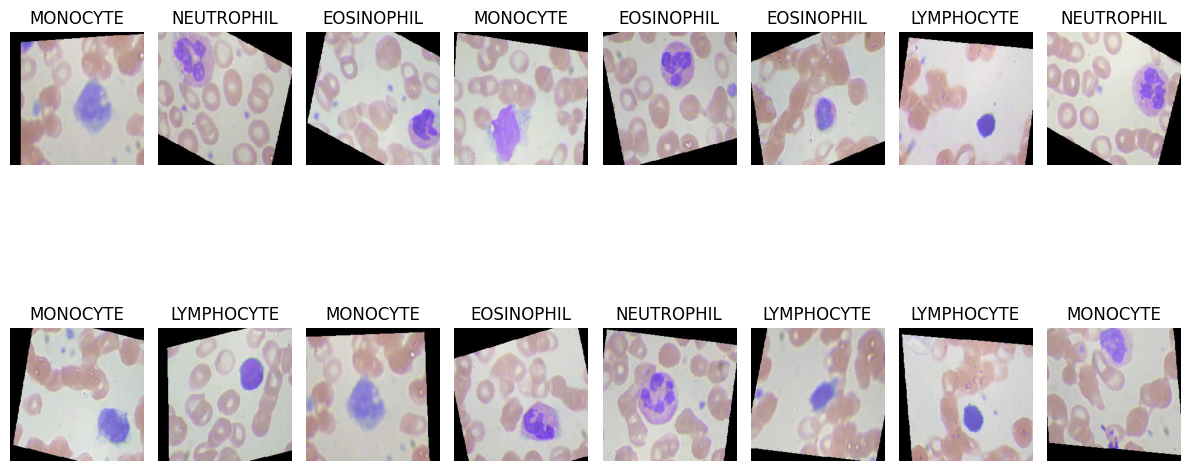

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

pre_trained_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(2e-5), metrics=["acc"]) # 2e-5

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

result = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

63/63 [==============================] - 4s 65ms/step - loss: 0.0299 - acc: 0.9920


[0.02988956682384014, 0.9919999837875366]

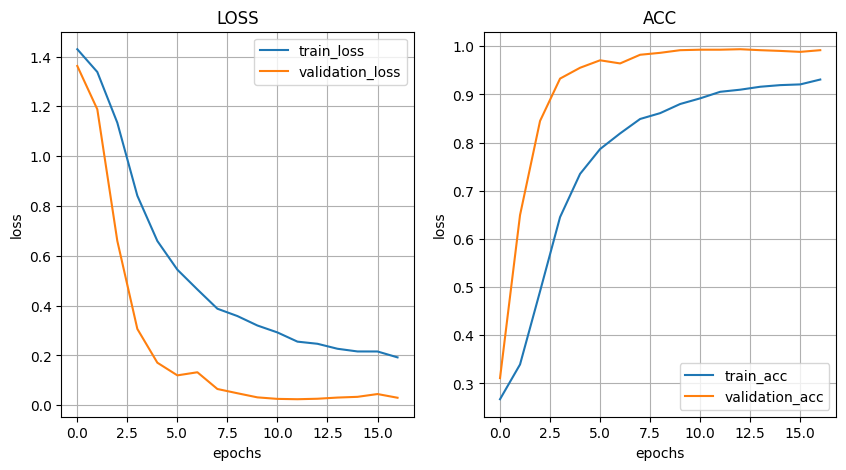

In [ ]:
# include_top = False
# ResNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")

model.evaluate(val_generator)